In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def correct_incorrect_losses(df):
    losses = df['reconstruction_losses'].values
    correct_indices = (df['predictions'] == df['labels'])
    correctly_classified_losses = losses[correct_indices]
    incorrectly_classified_losses = losses[np.invert(correct_indices)]
    return correctly_classified_losses, incorrectly_classified_losses

In [4]:
def histogram(arr, title=""):
    plt.hist(arr, bins=30)
    plt.title(title)
    plt.show()
    return

def overlapping_histograms(arrs, labels, title=""):
    plt.hist(arrs, label=labels, density=True, bins=30)
    plt.title(title)
    plt.legend()
    plt.show()
    return

In [117]:
def display_no_patch_recon_distributions(df):
    test = df[df['scales'] == 0]
    correct_losses, incorrect_losses = correct_incorrect_losses(test)
    critical_90 = np.percentile(correct_losses, 90)
    print("90th percentile of Correctly Classified Reconstruction Loss: " + str(critical_90))
    critical_95 = np.percentile(correct_losses, 95)
    print("95th percentile of Correctly Classified Reconstruction Loss: " + str(critical_95))
    critical_99 = np.percentile(correct_losses, 99)
    print("99th percentile of Correctly Classified Reconstruction Loss: " + str(critical_99))
    log_cl, log_icl = np.log(correct_losses), np.log(incorrect_losses)
    #overlapping_histograms([correct_losses,incorrect_losses], ["correct", "incorrect"], "Density of Correct and Incorrect Losses")
    overlapping_histograms([log_cl, log_icl], ["correct", "incorrect"], "Density of Log Correct and Log Incorrect Losses")
    return critical_90, critical_95, critical_99

In [123]:
def rates_by_scales(df, target_class:int, det_thres:float):
    def fooled_rate(data):
        # P(fooled)
        fooled = (data['predictions'] == target_class)
        num_fooled = np.count_nonzero(fooled)
        return num_fooled / len(fooled)
    def detection_rate(data):
        # P(detected)
        detected = (data['reconstruction_losses'] > det_thres)
        num_detected = np.count_nonzero(detected)
        return num_detected / len(detected)
    def success_rate(data):
        # P(fooled & undetected)
        fooled = (data['predictions'] == target_class)
        undetected = (data['reconstruction_losses'] < det_thres)
        successful = fooled & undetected
        return np.count_nonzero(successful) / len(successful)
    filtered = df[df['labels'] != target_class]
    fooled_rates = filtered.groupby('scales').apply(fooled_rate)
    detection_rates = filtered.groupby('scales').apply(detection_rate)
    success_rates = filtered.groupby('scales').apply(success_rate)
    return fooled_rates, detection_rates, success_rates
    

def display_scaled_patch_success_detection_rates(df, target_class:int, det_thres:float, title=""):
    fooled_rates, detection_rates, success_rates = rates_by_scales(df, target_class, det_thres)
    scales = fooled_rates.index
    plt.plot(scales, fooled_rates, '-o', label="APSR")
    plt.plot(scales, detection_rates, '-o', label="DPR")
    plt.plot(scales, success_rates, '-o', label="ASR")
    #plt.plot(scales, f_detection_rates, '-o', label="AFPR")
    plt.xlabel("Patch Scale")
    plt.legend(loc='upper left')
    plt.xticks(np.arange(0, 1, 0.1))
    plt.title(title)
    plt.show()
    print("APSR: adversarial partial success rate, proportions of patched images that fooled classification")
    print("DPR: detection positive rate, proportions of images that are detected as adversarial")
    print("ASR: adversarial success positive rate, proportions of patched images that fooled classifcation and detection")
    #print("AFPR: adversarial failure positive rate, proportions of adversarial failures that are detected as positive")


def display_scaled_recon_distributions(df, target_class:int):
    def plot_distribution(data):
        scale = data.scales.values[0]
        correct_losses, incorrect_losses = correct_incorrect_losses(data)
        #log_cl, log_icl = np.log(correct_losses), np.log(incorrect_losses)
        overlapping_histograms([correct_losses,incorrect_losses], ["correct", "incorrect"], "Density of Correct and Incorrect Losses, Patch Scaled by " + str(scale))
        #overlapping_histograms([log_cl, log_icl], ["correct", "incorrect"], "Density of Log Correct and Log Incorrect Losses, Patch Scaled by " + str(scale))
        return 0
    filtered = df[df['labels'] != target_class]
    filtered.groupby('scales').apply(plot_distribution)

In [124]:
import os
import re
def patches_into_table(data_dir, threshold, scale_out_of_ten=3, target_class=0):
    regex = re.compile('\S*png_test.csv')
    patch_success_rates = {}
    total = 0
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if regex.match(file):
                total += 1
                path = os.path.join(data_dir, file)
                fooled_rates, detection_rates, success_rates = rates_by_scales(pd.read_csv(path), target_class, threshold)
                fooled_rate = fooled_rates.values[scale_out_of_ten]
                success_rate = success_rates.values[scale_out_of_ten]
                detection_rate = detection_rates.values[scale_out_of_ten]
                patch_success_rates[file] = (success_rate, fooled_rate, detection_rate)
    patches_sorted_by_success = sorted(patch_success_rates.items(), key=lambda item:item[1][0])
    patches = pd.DataFrame(patches_sorted_by_success, columns=['File', 'Rates'])
    patches['Success'] = patches['Rates'].apply(lambda item:item[0])
    patches['Fooled'] = patches['Rates'].apply(lambda item:item[1])
    patches['Detected'] = patches['Rates'].apply(lambda item:item[2])
    patches['Decreased_Adv_Effectiveness_By'] = 1 - (patches['Success']/patches['Fooled'])
    pd.set_option('display.max_rows', total)
    print(patches[['File', 'Success','Decreased_Adv_Effectiveness_By', 'Detected']])

In [142]:
def visualize_patches_results(data_dir):
    regex = re.compile('\S*png_test.csv')
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if regex.match(file):
                recon_loss_dataset = os.path.join(patches_dir, file)
                break
        break
    recon_losses = pd.read_csv(recon_loss_dataset)
    crit_90, crit_95, crit_99 = display_no_patch_recon_distributions(recon_losses)
    print("\nFPR = 10%")
    patches_into_table(patches_dir, crit_90, 4)
    print("\nFPR = 5%")
    patches_into_table(patches_dir, crit_95, 4)
    print("\nFPR = 1%")
    patches_into_table(patches_dir, crit_99, 4)

90th percentile of Correctly Classified Reconstruction Loss: 0.038417149000000005
95th percentile of Correctly Classified Reconstruction Loss: 0.04486830825
99th percentile of Correctly Classified Reconstruction Loss: 0.058640876030000004


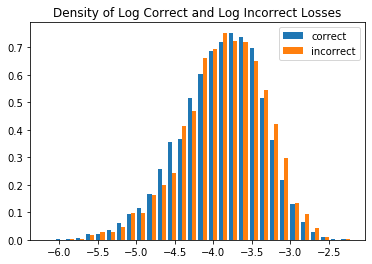


FPR = 10%
                                                 File   Success  \
0   logs_cifar10_adv_tenk_20200111_16_41_45_249320...  0.025222   
1   logs_cifar10_adv_thousand_20200111_16_41_22_89...  0.027667   
2   logs_cifar10_adv_hundred_20200111_16_41_05_447...  0.031444   
3   logs_cifar10_adv_00_20200111_16_33_34_061935__...  0.255667   
4   logs_cifar10_adv_15_20200111_16_33_34_061112__...  0.283444   
5   logs_cifar10_adv_05_20200111_16_33_34_061446__...  0.283667   
6   logs_cifar10_adv_10_20200111_16_33_34_061579__...  0.287222   
7   logs_cifar10_adv_20_20200111_16_33_34_061447__...  0.314778   
8   logs_cifar10_adv_ten_20200111_16_40_54_114529_...  0.315333   
9   logs_cifar10_adv_25_20200111_16_33_34_061916__...  0.323111   
10  logs_cifar10_adv_30_20200111_16_33_48_531391__...  0.324667   
11  logs_cifar10_adv_35_20200111_16_35_18_621573__...  0.326889   
12  logs_cifar10_adv_40_20200111_16_35_44_303662__...  0.334889   
13  logs_cifar10_adv_50_20200111_16_40_30_610816__.

In [143]:
patches_dir = "logs/cifar10/bg_recon_2/20191225_13:38:42:637171_/test"
visualize_patches_results(patches_dir)

90th percentile of Correctly Classified Reconstruction Loss: 0.023412964900000003
95th percentile of Correctly Classified Reconstruction Loss: 0.02805054454999995
99th percentile of Correctly Classified Reconstruction Loss: 0.038876173199999996


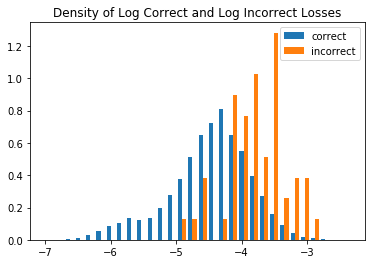


FPR = 10%
                                                 File   Success  \
0   logs_mnist_adv_05_20191224_14_09_23_834357__te...  0.000000   
1   logs_mnist_adv_0_20191224_14_02_41_630783__tes...  0.000111   
2   logs_mnist_adv_10_20191224_14_09_23_820164__te...  0.000333   
3   logs_mnist_adv_10000_20191224_14_57_26_013935_...  0.000776   
4   logs_mnist_adv_3_20191224_14_10_22_144123__tes...  0.000887   
5   logs_mnist_adv_100_20191224_14_57_26_013646__t...  0.000887   
6   logs_mnist_adv_1000_20191224_14_57_26_013433__...  0.000887   
7   logs_mnist_adv_45_20191224_14_11_08_153872__te...  0.000998   
8   logs_mnist_adv_4_20191224_14_10_52_515839__tes...  0.000998   
9   logs_mnist_adv_15_20191224_14_09_29_196631__te...  0.001220   
10  logs_mnist_adv_5_20191224_14_11_25_796435__tes...  0.001330   
11  logs_mnist_adv_2_20191224_14_09_44_932102__tes...  0.001441   
12  logs_mnist_adv_35_20191224_14_10_34_216268__te...  0.001663   
13  logs_mnist_adv_ten_20191224_14_57_26_013926__t.

In [144]:
patches_dir = "logs/mnist/new_recon_custom_weightreg_dropout/20191202_13:41:11:544060_/test"
visualize_patches_results(patches_dir)

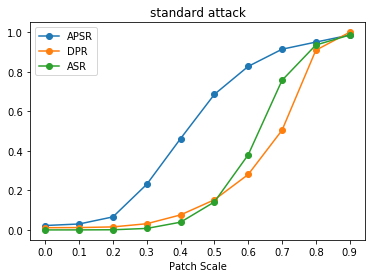

APSR: adversarial partial success rate, proportions of patched images that fooled classification
DPR: detection positive rate, proportions of images that are detected as adversarial
ASR: adversarial success positive rate, proportions of patched images that fooled classifcation and detection


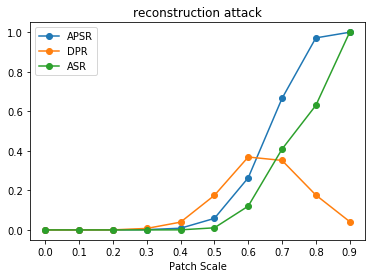

APSR: adversarial partial success rate, proportions of patched images that fooled classification
DPR: detection positive rate, proportions of images that are detected as adversarial
ASR: adversarial success positive rate, proportions of patched images that fooled classifcation and detection


In [27]:
display_scaled_patch_success_detection_rates(standard, target_class=0, det_thres=crit_99, title="standard attack")
display_scaled_patch_success_detection_rates(adaptive, target_class=0, det_thres=crit_99, title="reconstruction attack")

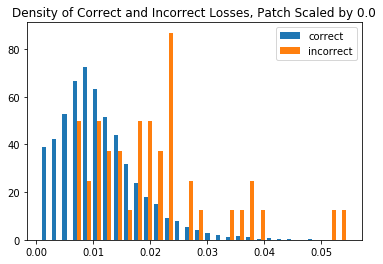

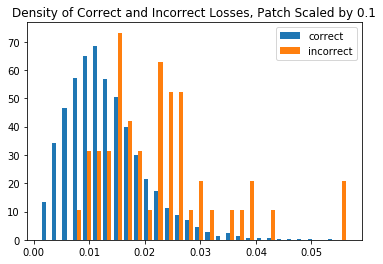

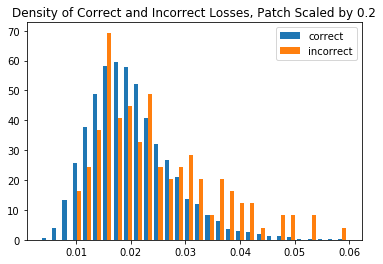

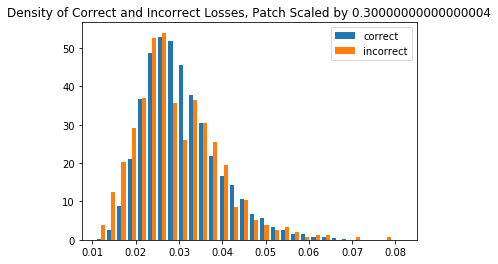

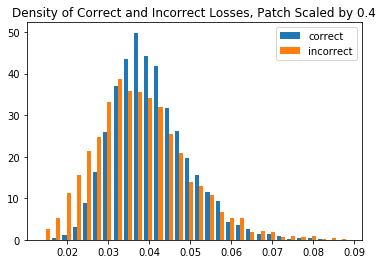

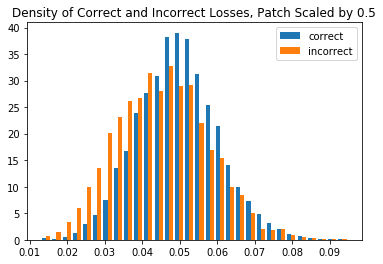

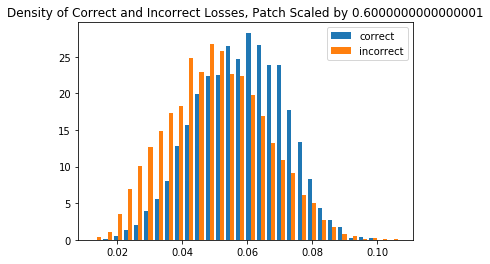

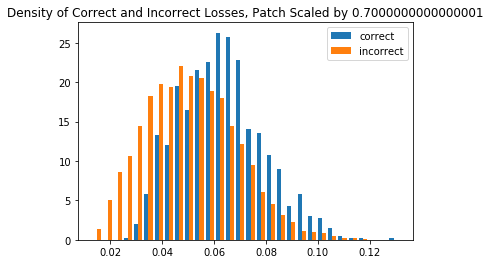

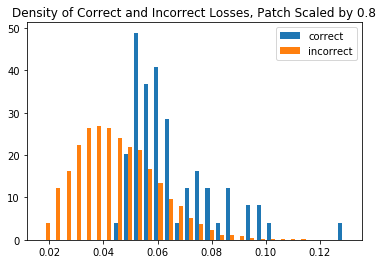

/home/perry/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


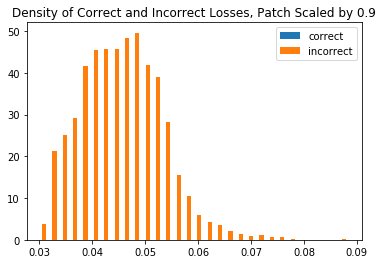

In [19]:
display_scaled_recon_distributions(adaptive, target_class=0)